# Estimation de l'ATE/CATE sur des données synthétiques

In [1]:
import numpy as np
from scipy.stats import bernoulli
import scipy as sp
from scipy import stats
from scipy import integrate
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install causalml

In [3]:
import causalml

## Génération de données

In [4]:
def treatment_assign(Nobs, X, p):
    '''
    Input: 
    
    p : score de propension.
    Nobs : Nombre de lignes da la matrice X i.e. nombre de personnes.
    
    Output:
    
    W : Vecteur de taille Nobs contenant des 0 ou 1 pour désigner l'affectation du traitement.
    '''
    sigmoid = lambda x: 1/(1+np.exp(-x))
    
    omega = np.random.uniform(0, 1, (Nobs, d))
    psi = np.random.uniform(0, 1, (Nobs, 1))

    if p == None:
      p = np.zeros(Nobs)
      for i in range(Nobs):
        p[i] = sigmoid(omega[i] @ X[i])
      W = bernoulli.rvs(p, size = Nobs) 
    else:
      W = bernoulli.rvs(p, size = Nobs) 
    
    return W

In [5]:
def causal_generation(Nobs, dim, beta, bias, f, g, p):
    '''
    Input :
    
    Nobs : Nombre de lignes da la matrice X i.e. nombre de personnes.
    dim : Nombre de colonnes de la matrice X i.e. nombres de caractéristiques (features).
    beta : Vecteur de dimension (2, dim).
    bias : Vecteur de dimension (1, 2).
    W : Vecteur de dimension (1, Nobs) contenant des 0 ou 1 pour désigner l'affectation du traitement.
    f et g sont des fonctions.
    
    Output:
    
    (X, Y, W) : Triplet contenant la matrice X des features, Y le vecteur des résultats potentiels et 
                W le vecteur de l'affectation du traitement.
    '''
    moy = np.zeros(dim)
    var = np.eye(dim)
    X = np.random.multivariate_normal(moy, var, Nobs)
    Y = np.zeros(Nobs)

    W = treatment_assign(Nobs, X, p)

    for i in range(N):
        bruit = np.random.normal(0, 1)
        if W[i] == 0:
            Y[i] = f(beta[0] @ X[i] + bias[0]) + bruit
        if W[i] == 1:
            Y[i] = g(beta[1] @ X[i] + bias[1]) + bruit
            
    return (X, W, Y)

## S-learners

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SLearner(BaseEstimator, ClassifierMixin):
    """ Homemade SLearner class """
    
    def __init__(self, base_estimator=LinearRegression()):
        # init
        self.estimator = base_estimator
        
    def fit(self, X, W, Y):
        # Initiation des variables
        self.X = X
        self.W = W
        self.Y = Y
        self.features = np.hstack((self.X, self.W[:,np.newaxis]))
        self.clf = self.estimator.fit(self.features, self.Y)

    def predict_CATE(self, x):
        # Complete the method      
        self.Y_0_hat = self.clf.predict(np.c_[x, np.zeros(len(x))])
        self.Y_1_hat = self.clf.predict(np.c_[x, np.ones(len(x))])
        return self.Y_1_hat - self.Y_0_hat

    def predict_ATE(self):
        return (self.Y_1_hat - self.Y_0_hat).mean()

## T-learners

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin

class TLearner(BaseEstimator, ClassifierMixin):
    """ Homemade SLearner class """
    
    def __init__(self, base_estimator0=LinearRegression(), base_estimator1=LinearRegression() ):
        # init
        self.estimator0 = base_estimator0
        self.estimator1 = base_estimator1

    def fit(self, X, W, Y):
        # Initiation des variables
        self.X = X
        self.W = W
        self.Y = Y
        self.mu_0 = self.estimator0.fit(X[self.W==0,:], self.Y[self.W==0])
        self.mu_1 = self.estimator1.fit(X[self.W==1,:], self.Y[self.W==1])

    def predict_CATE(self, x):
        # Complete the method         
        self.Y_0_hat = self.mu_0.predict(x)
        self.Y_1_hat = self.mu_1.predict(x)
        return self.Y_1_hat - self.Y_0_hat

    def predict_ATE(self):
        return (self.Y_1_hat - self.Y_0_hat).mean()

## X-Learners (à faire)

## Phase de test ( cas simple)

### Initialisation des paramètres (cas simple)

In [8]:
# paramètres pour faciliter le calcul de l'ATE par intégration
N = 1000
d = 2                                 # d = 2, afin de pouvoir être calculé par intégration et avec Monte Carlo
p = 0.5
beta = np.random.uniform(1, 30, (2, d))                   
bias = np.random.uniform(1, 30, (2, 1))                  
f = lambda x:np.cos(x)
g = lambda x:x

In [9]:
print(beta)
print(bias)

[[19.50102888 27.10462507]
 [13.41257323 27.40679642]]
[[ 8.84675951]
 [27.16548463]]


### Générations des données (cas simple)

In [10]:
# Génération des données
X, W, Y = causal_generation(N, d, beta, bias, f, g, p = None)

### Prédictions des métalearners "Team Filrouge"

#### Slearners

In [11]:
slearner=SLearner(base_estimator=LinearRegression())
slearner.fit(X, W, Y)

cate_hat_S = slearner.predict_CATE(X)
print("- Les dimensions du CATE = {}.".format(cate_hat_S.shape))

ate_hat_S = slearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE = {}.".format(ate_hat_S))

- Les dimensions du CATE = (1000,).
- L'estimation de la valeur de l'ATE = 26.634474605193063.


#### Tlearners

In [12]:
tlearner=TLearner(base_estimator0=LinearRegression(), base_estimator1=LinearRegression())
tlearner.fit(X,W,Y)

cate_hat_T = tlearner.predict_CATE(X)
print("- Les dimensions du CATE = {}.".format(cate_hat_T.shape))

ate_hat_T = tlearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE = {}.".format(ate_hat_T))

- Les dimensions du CATE = (1000,).
- L'estimation de la valeur de l'ATE = 27.180075587172905.


### Prédictions des métalearners "Causal ML"

#### Slearners

In [13]:
from causalml.inference.meta import LRSRegressor
from xgboost import XGBRegressor


lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(X, W, Y)
print('L\'estimation de la valeur de l\'ATE (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

L'estimation de la valeur de l'ATE (Linear Regression): 26.63 (24.55, 28.71)


#### Tlearners

In [14]:
from causalml.inference.meta import XGBTRegressor

xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X, W, Y)
print('L\'estimation de la valeur de l\'ATE (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

[08:39:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:39:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
L'estimation de la valeur de l'ATE (XGBoost): 27.55 (25.66, 29.44)


### Paradis

In [15]:
def ATE_paradis(beta, bias, f=lambda i:i, g=lambda i:i):
  d = beta.shape[1]
  if d==1:
    ate = integrate.quad(lambda x: (g(beta[1]*x + bias[1]) -f(beta[0]*x + bias[0]))*sp.stats.norm.pdf(x,0,1),-1000 , 1000)
  if d==2:
    ate=integrate.dblquad(lambda x, y: (g(beta[1,0]*x + beta[1,1]*y + bias[1]) -f(beta[0,0]*x + beta[0,1]*y + bias[0])
    )*sp.stats.norm.pdf(x,0,1)*sp.stats.norm.pdf(y,0,1),-1000 , 1000, lambda y :-1000,lambda y : 1000)
  if d>2:
    return 'dimension above 2'
  return  ate

In [16]:
def monte_carlo(Nobs, dim, beta, bias, f, g):
    '''
    Input :
    
    Nobs : Nombre de lignes da la matrice X i.e. nombre de personnes.
    dim : Nombre de colonnes de la matrice X i.e. nombres de caractéristiques (features).
    beta : Vecteur de dimension (2, dim), note dim doit être < 10
    bias : Vecteur de dimension (1, 2).
    W : Vecteur de dimension (1, Nobs) contenant des 0 ou 1 pour désigner l'affectation du traitement.
    f et g sont des fonctions.
    
    Output:
    
    ATE : ATE calculé par la méthode de Monte Carlo
    '''
    moy = np.zeros(dim)
    var = np.eye(dim)
    X = np.random.multivariate_normal(moy, var, Nobs)
    ATE = np.mean(g(X.dot(beta[1])+ bias[1]) - f(X.dot(beta[0])+ bias[0])) 
            
    return ATE

In [17]:
print('ATE: {}'.format(ATE_paradis(beta, bias, f=f, g=g)))
print('ATE par monte carlo: {}'.format(monte_carlo(10**6, d, beta, bias, f, g)))

ATE: (27.165484628812692, 2.1167620941414851e-07)
ATE par monte carlo: 27.189074990143


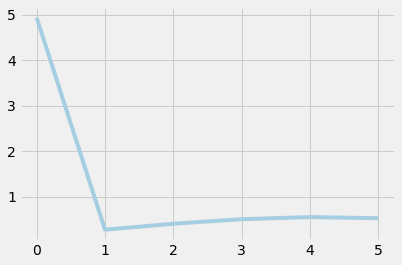

In [18]:
res = []
#1- varier Nobs pour ate_hat_S et le comparer avec mc_est (meth. monte carlo) avec 10**8
#2 - ajouter une courbe avec l'estimation avec causalml avec la borne inf et max et ate_hat_S
for i in range(2,8):
    mc_est = monte_carlo(10**i, d, beta, bias, f, g)
    res.append([abs(mc_est - ate_hat_S)])
plt.figure()
plt.plot(res)